In [34]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Reading image
img_path = "../../images/"
img_name = "colorful_apples_2.jpg"
img = cv.imread(img_path + img_name, cv.IMREAD_COLOR)

In [36]:
# Convert to CIE Lab color space and then split into components
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
img_lab_l, img_lab_a, img_lab_b = cv.split(img_lab)

In [37]:
# Set number of color segments
col_seg_num = 4

In [38]:
# Define areas
sample_areas = []
def mouse_handler(event, x, y, flags, param):
    if event != cv.EVENT_LBUTTONDBLCLK:
        return
    sample_areas.append((x, y))

cv.imshow("Image", img)
cv.setMouseCallback("Image", mouse_handler)
while len(sample_areas) < col_seg_num:  # Interactive loop
    cv.waitKey(20)
cv.setMouseCallback("Image", lambda *args : None)
cv.destroyAllWindows()

In [39]:
# Compute means in the circle areas of selected pixels
color_marks = []
color_marks_bgr = []
for pix in sample_areas:
    mask = np.zeros_like(img_lab_l)
    cv.circle(mask, pix, 10, 255, -1)  # Draw circle
    a = img_lab_a.mean(where = mask > 0)
    b = img_lab_b.mean(where = mask > 0)
    color_marks.append((a, b))
    color_marks_bgr.append(img[mask > 0, :].mean(axis=0))

In [40]:
print(color_marks)
print(color_marks_bgr)

[(121.82649842271293, 203.3249211356467), (104.45425867507886, 197.71293375394322), (186.17350157728706, 165.67192429022083), (128.84858044164037, 131.04731861198738)]
[array([ 60.09148265, 217.81388013, 245.36908517]), array([ 13.9873817 , 182.59936909, 166.30914826]), array([ 33.23343849,  21.86119874, 179.27444795]), array([29.60567823, 34.03470032, 38.170347  ])]


In [41]:
# Calculate the distance between all pixels in initial image and previously selected pixels
distance = []
for color in color_marks:
    distance.append(np.sqrt(np.power(img_lab_a - color[0], 2) + np.power(img_lab_b - color[1], 2)))

In [42]:
# Estimate minimum of all pixels
distance_min = np.minimum.reduce(distance, axis=0)

In [43]:
# Find labels of all pixels
labels = np.zeros_like(img[:, :, 0], dtype=np.uint8)
for i in range(len(color_marks)):
    mask = distance_min == distance[i]
    labels[mask] = i

In [44]:
# Segment the source image to a set of segmented images
segmented_frames = []
for i in range(len(color_marks)):
    img_buf = np.zeros_like(img)
    mask = labels == i
    img_buf[mask] = img[mask]
    segmented_frames.append(img_buf)

In [45]:
# Plot distribution of image pixel colors in (a, b) coordinate system
img_plot = np.full((256, 256, 3), 255, dtype=np.uint8)
for i in range(len(color_marks)):
    img_buf = np.zeros_like(img)
    mask = labels == i
    img_plot[img_lab_a[mask], img_lab_b[mask], :] = color_marks_bgr[i]

True

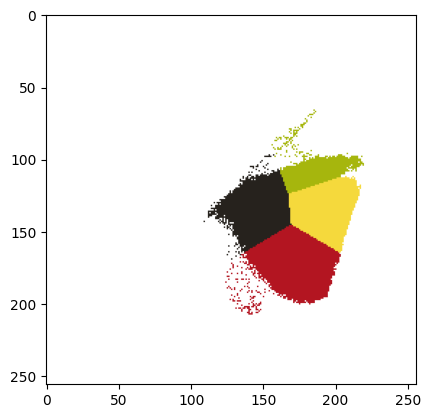

In [49]:
# Show distribution plot
plt.imshow(cv.cvtColor(img_plot, cv.COLOR_BGR2RGB))
# Save this plot
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_distr_plot.jpg", img_plot)

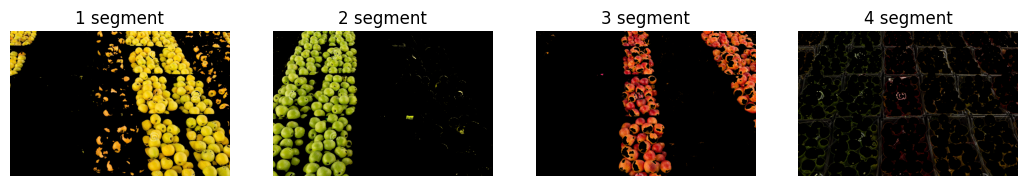

In [51]:
# Show segmented frames
fig = plt.figure(figsize=(13, 9))
for i in range(1, col_seg_num + 1):
    fig.add_subplot(1, 4, i)
    plt.imshow(cv.cvtColor(segmented_frames[i - 1], cv.COLOR_BGR2RGB))
    plt.title(str(i) + " segment")
    plt.axis('off')
    cv.imwrite(img_path + img_name.rpartition('.')[0] + '_' + str(i) + "_segment.jpg", segmented_frames[i - 1])

True

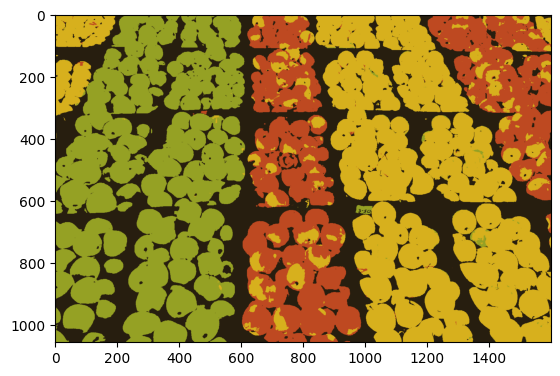

In [59]:
# Construct general photo
# Assign the segments with its mean intensities
img_gen = np.copy(img)
for i in range(col_seg_num):
    mask = labels == i
    img_gen[mask] = np.mean(img[mask], axis=0)
plt.imshow(cv.cvtColor(img_gen, cv.COLOR_BGR2RGB))
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_gen_img.jpg", img_gen)